In [1]:
# This code was update/modified from https://github.com/Qiskit/textbook/blob/main/notebooks/ch-applications/qaoa.ipynb
from braket.aws.aws_session import AwsSession 
import boto3
import os 
from dotenv import load_dotenv
from qiskit import *
from qiskit_braket_provider import BraketProvider
from qiskit.visualization import plot_histogram
from matplotlib import pyplot

# Circuit Specific Imports
from qiskit.circuit import Parameter
from scipy.optimize import minimize

Section - Backend Setup and Graph Definition

In [2]:
# Load environment variables 
load_dotenv()

boto_session = boto3.Session(
    aws_access_key_id=os.environ['aws_access'],
    aws_secret_access_key=os.environ['aws_secret'],
    region_name=os.environ['aws_region'],
)
session = AwsSession(boto_session)
provider = BraketProvider()
backend = provider.get_backend("SV1", aws_session = session)

# Define a graph representing a square. Each node is identified by an integer.
graph = {
    "nodes": [0,1,2,3],
    "edges": [(0, 1), (1, 2), (2, 3), (3, 0)]
}

NODES = "nodes"
EDGES = "edges"

Section - Maxcut Cost

In [3]:
def maxcut_cost(solution, graph):
    """Calculates the cost (negative of the number of edges cut) for a given solution.

    Args:
        solution (string): A binary string representing the set assignment of each vertex.
        graph (dict): A dictionary representing the graph, with keys "nodes" and "edges."

    Returns:
        int: The cost (negative of the number of edges cut) for the given solution.
    """
    cost = 0
    for i, j in graph[EDGES]:
        if solution[i] != solution[j]:
            cost -= 1
    return cost

Section - Expected Value

In [4]:
def compute_expectation(counts, graph):
    """Calculates the expected value of the cost function given measurement results.

    Args:
        counts (dict): A dictionary mapping bitstrings to their counts from quantum circuit execution.
        graph (dict): A dictionary representing the graph, with keys "nodes" and "edges."

    Returns:
        float: The expected value of the cost function.
    """
    avg = 0
    sum_count = 0
    for bit_string, count in counts.items():
        obj = maxcut_cost(bit_string, graph)
        avg += obj * count
        sum_count += count
    return avg/sum_count

Section - Circuit Creation

In [5]:
def create_qaoa_circ(graph, theta):
    """Constructs a parameterized QAOA circuit for the Max-Cut problem.

    Args:
        graph (dict): A dictionary representing the graph, with keys "nodes" and "edges."
        theta (list): A list of unitary parameters

    Returns:
        QuantumCircuit: The constructed QAOA circuit.
    """
    nqubits = len(graph[NODES]) # Number of Qubits
    n_layers = len(theta)//2    # Number of alternating unitaries
    beta = theta[:n_layers]
    gamma = theta[n_layers:]
    qc = QuantumCircuit(nqubits)

    # Initial_state
    qc.h(range(nqubits))

    for layer_index in range(n_layers):
        # Problem unitary
        for pair in list(graph[EDGES]):
            qc.rzz(2 * gamma[layer_index], pair[0], pair[1])
        # Mixer unitary
        for qubit in range(nqubits):
            qc.rx(2 * beta[layer_index], qubit)
    qc.measure_all()
    return qc

Section - Calculate Expected Value

In [6]:
def get_expectation(graph, backend, shots=512):
    """Calculates the expected value of the cost function given measurement results.

    Args:
        counts (dict): A dictionary mapping bitstrings to their counts from quantum circuit execution.
        graph (dict): A dictionary representing the graph, with keys "nodes" and "edges."

    Returns:
        float: The expected value of the cost function.
    """
    def execute_circ(theta):
        """Executes the QAOA circuit with given parameters and returns the expectation value."""
        qc = create_qaoa_circ(graph, theta)
        qc_compiled = transpile(qc, backend)
        job_sim = backend.run(qc_compiled, shots=shots)
        counts = job_sim.result().get_counts()
        return compute_expectation(counts, graph)
    return execute_circ

Section - Optimizing Circuit

In [7]:
# Get the function to calculate expectation for optimization
expectation = get_expectation(graph, backend)

res = minimize(expectation,
               [1.0, 1.0],      # Initial guess for parameters
               method='COBYLA') # Classical optimization method
# Print the result of the minimization function
print(res)

c:\Users\Lowkey\Documents\Code\QuantumSetup.git\.venv\Lib\site-packages\qiskit_braket_provider\providers\adapter.py:457: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn(
c:\Users\Lowkey\Documents\Code\QuantumSetup.git\.venv\Lib\site-packages\qiskit_braket_provider\providers\adapter.py:457: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn(
c:\Users\Lowkey\Documents\Code\QuantumSetup.git\.venv\Lib\site-packages\qiskit_braket_provider\providers\adapter.py:457: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn(
c:\Users\Lowkey\Documents\Code\QuantumSetup.git\.venv\Lib\site-packages\qiskit_braket_provider\providers\adapter.py:457: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn(
c:\Users\Lowkey\Documents\Code\QuantumSetup.git\.venv\Lib\site-packages\qiskit_braket_provider\providers\adapter.py:457: UserWar

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -2.96484375
       x: [ 2.797e+00  3.769e-01]
    nfev: 34
   maxcv: 0.0


Section - Optimized Circuit

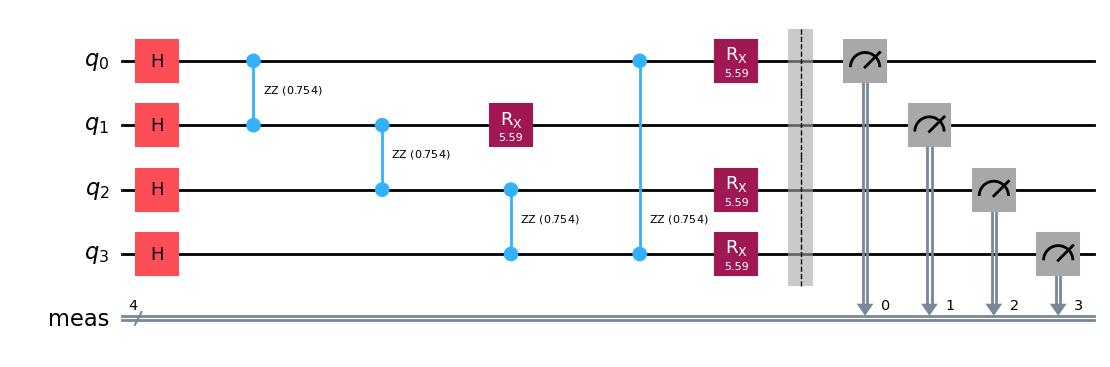

In [8]:
# Create the final circuit with optimized parameters
qc_res = create_qaoa_circ(graph, res.x)

# Draw the final circuit
qc_res.draw("mpl")

Section - Circuit Execution and Result Analysis

c:\Users\Lowkey\Documents\Code\QuantumSetup.git\.venv\Lib\site-packages\qiskit_braket_provider\providers\adapter.py:457: UserWarning: The Qiskit circuit contains barrier instructions that are ignored.
  warnings.warn(


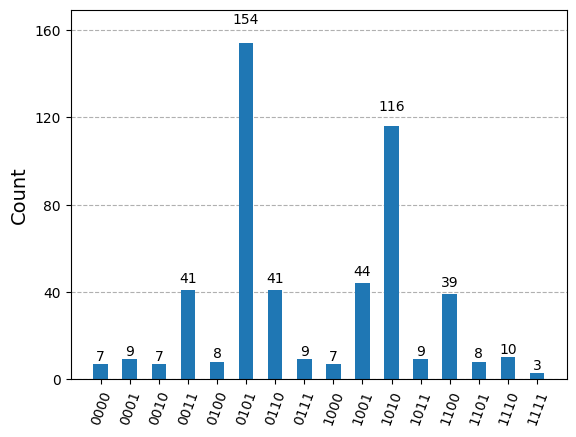

In [9]:
# Execute the circuit and visualize results
qc_compiled = transpile(qc_res, backend)
job_sim = backend.run(qc_compiled, shots=512)
counts = job_sim.result().get_counts()

# Expected spikes at the solutions ["1010", "0101"]
plot_histogram(counts)